In [1]:
from tensorflow import keras

import math
import random
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.losses as losses

img_path: data/images/Birman_100.jpg
mask_path: data/annotations/trimaps/Birman_100.png


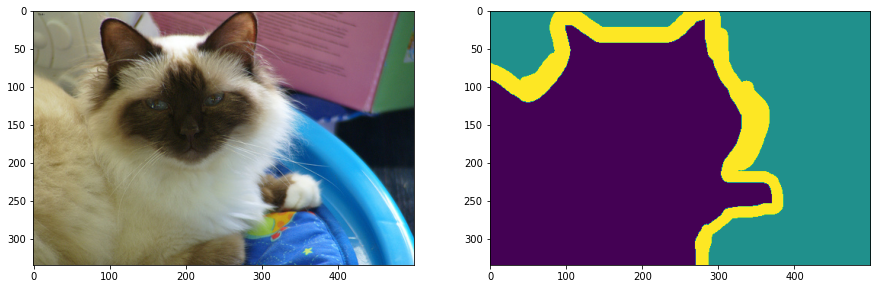

In [2]:
# kfolds.csv를 읽어 데이터프레임으로 저장하고 그 중 랜덤한 idx를 뽑아 이미지와 마스크 이미지를 출력
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

file_name = df.loc[idx].file_name
img_path = f'data/images/{file_name}.jpg'
mask_path = f'data/annotations/trimaps/{file_name}.png'

print('img_path:', img_path)
print('mask_path:', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [3]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train': # train 이미지
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # {image = image, mask = mask}
        if self.transform: # 섞어준다.
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image']
            mask = augmented['mask']
            
            return img,mask

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0 # 배경 날려버리기
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image, mask = self.transform(image=image, mask = mask)
                
            
            image = image.astype('float32')            
            image = image / 255.
            
            batch_x.append(image)
            batch_y.append(mask)
            
        return batch_x, batch_y

In [8]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

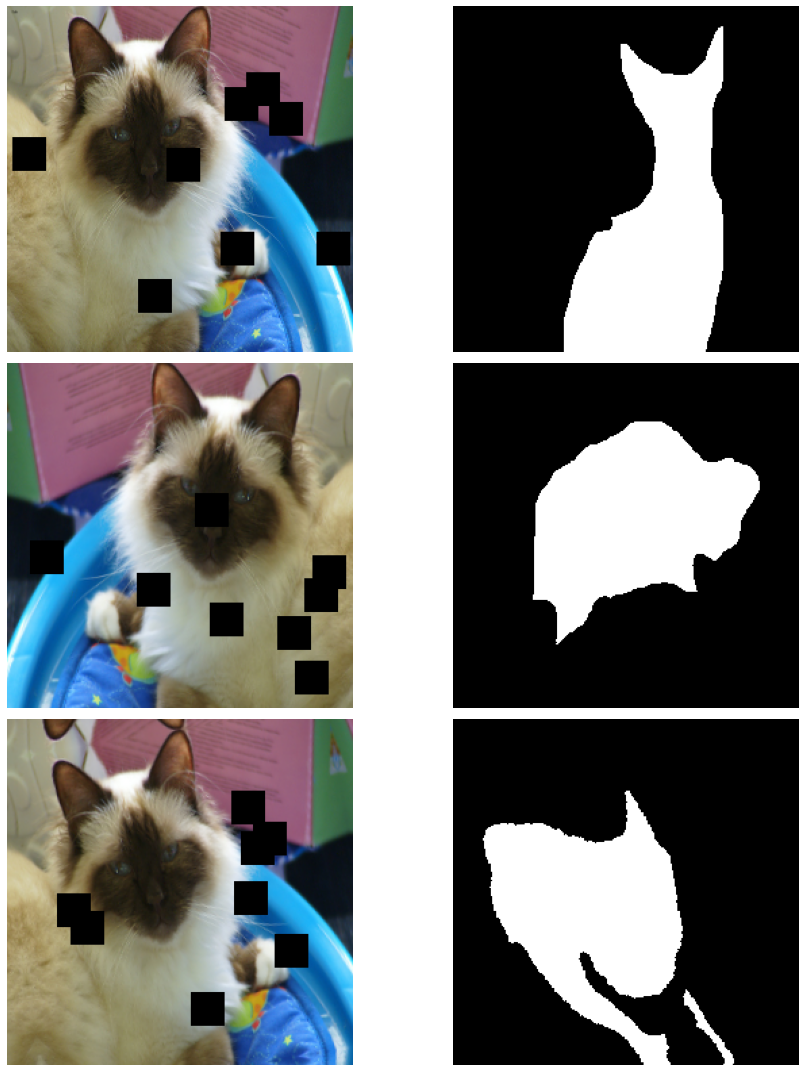

In [9]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(3):
        plt.subplot(3, 2, i*2 + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.subplot(3, 2, i*2 + 2)
        plt.imshow(y[i], cmap='gray')
        plt.axis('off')
        plt.tight_layout()
    break